In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyabf
from pathlib import Path
from scipy.signal import find_peaks 
import abf_to_grid as ag
%matplotlib widget
import importlib

# from asymmetry import abf_to_data as ad
# from asymmetry import utils

In [2]:
file_path = Path(r'C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\2\17503013_rec.abf')
file_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\3\17809006.abf")
file_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\4\17726004.abf")
file_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\18427009.abf") # 10x10 max separation

file_path10 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\18427010.abf") # 29x29
protocol_path10 =  Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\rand29x29_50perc20ms.txt")

# file_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\18427011.abf") # 59roi29
# file_path = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\6\Expt1_300517.mat") # CaMK18 300517

protocol_path0 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\10x10_100perc_10ms.txt")

protocol_path1 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\Aug18\Grid_29x29_50perc_10ms_rand.txt") #x
protocol_path3 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\others\Polygon-May2017\300517-random29x2910ms50percent.txt") #x
protocol_path4 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\Aug18\29x29_50perc_10ms_rand.txt")
protocol_path5 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\Sep18\29x29_50perc_10ms_rand.txt")
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\5\Expt10_29x29rand_50perc_20ms\Grid59roi29_random.txt")
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\59xgrid29roi_100perc10ms.txt")

Loading ABF file
Datafile has 1 sweeps in 2 channels.


c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


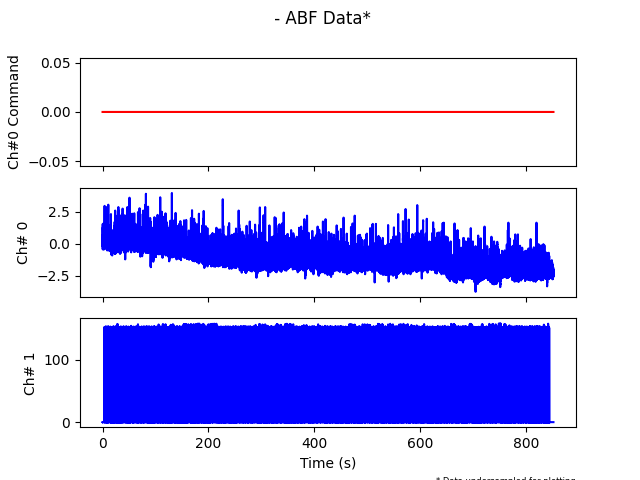

Cell data shape:  (17048576,)
Number of stimulations:  841
[  2.836    3.8378   4.8399 ... 842.3503 843.3522 844.3553]


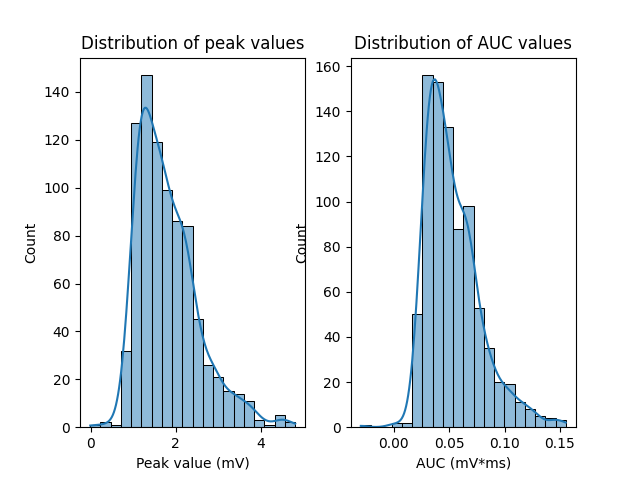

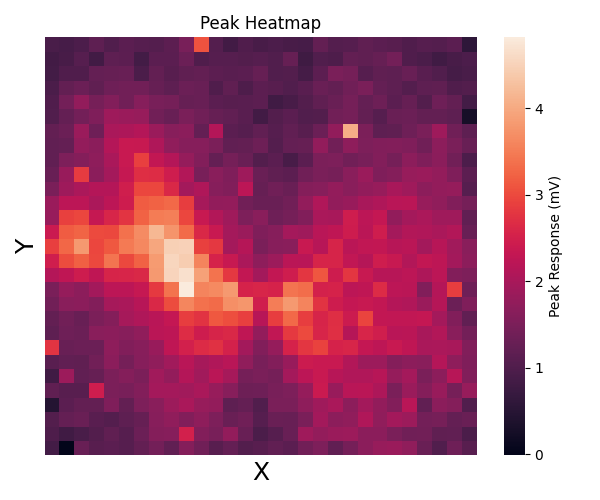

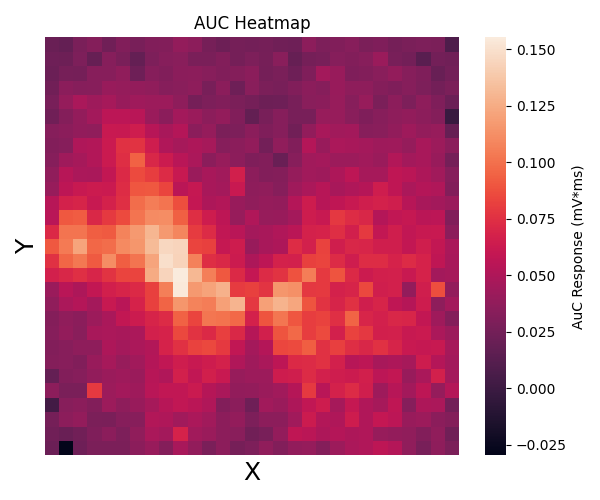

In [3]:
fig_folder = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots")
plt.close('all')
importlib.reload(ag)

# stim_times = np.arange(49743, 16869273, 20000)[:834]
stim_times, peak_df, df_pivot_peak, df_pivot_auc, fig1, fig2, _, _ = ag.plot_heatmap(file_path10, protocol_path10,stim_times=None,expected_stims=841,clip_value=30,stim_threshold=10,protocol_order='random')
# save fig1 and fig2 as svg and png
filename_prefix = f'CaMKII_27Apr18_expt10'
# if peak_df is not None:
#     fig1.savefig(fig_folder / f'{filename_prefix}_histogram.svg')
#     fig1.savefig(fig_folder / f'{filename_prefix}_histogram.png')
#     fig2[0].savefig(fig_folder / f'{filename_prefix}_peak_heatmap.svg')
#     fig2[0].savefig(fig_folder / f'{filename_prefix}_peak_heatmap.png')
#     fig2[1].savefig(fig_folder / f'{filename_prefix}_auc_heatmap.svg')
#     fig2[1].savefig(fig_folder / f'{filename_prefix}_auc_heatmap.png')

In [44]:
kernel = 5*df_pivot_peak.to_numpy()
kernel = kernel[5:,:].T

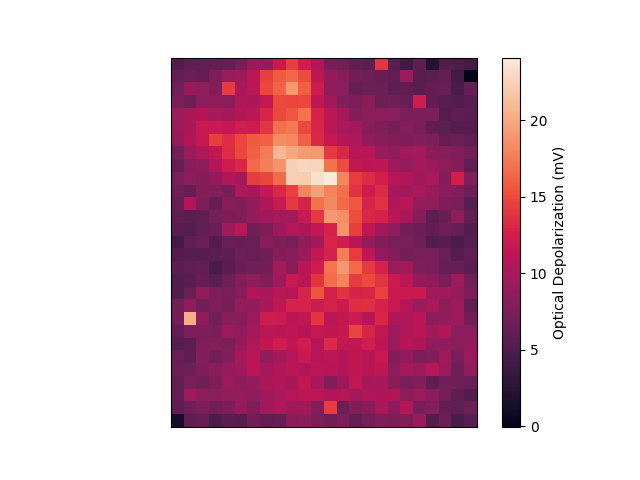

In [60]:
# plot matplotlib heatmap of the kernel
plt.figure()
# layout tight
plt.tight_layout()
plt.imshow(kernel, cmap='rocket', interpolation='nearest')
# remove ticks and labels
plt.xticks([])
plt.yticks([])
# add colourbar axis label
cbar = plt.colorbar()
cbar.set_label('Optical Depolarization (mV)')
# save as svg and png
plt.savefig(fig_folder / f'kernel_convolution_kernel.svg')
plt.savefig(fig_folder / f'kernel_convolution_kernel.png')

actual number of neurons activated: 1084.0
actual number of neurons activated: 480.0
actual number of neurons activated: 178.0
actual number of neurons activated: 38.0
actual number of neurons activated: 3.0


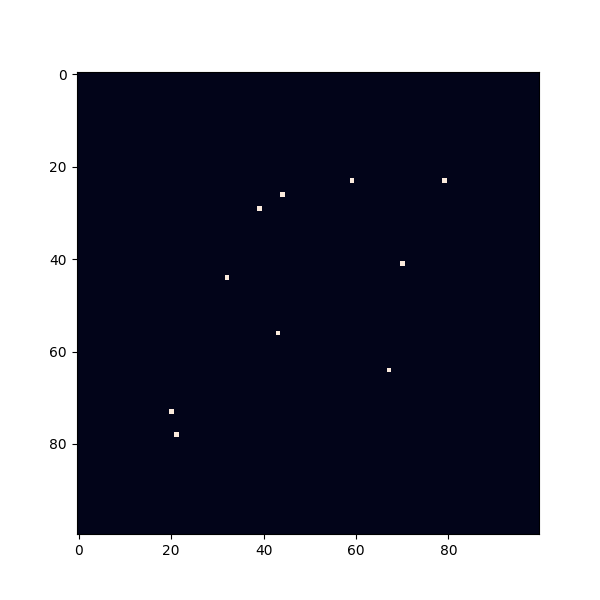

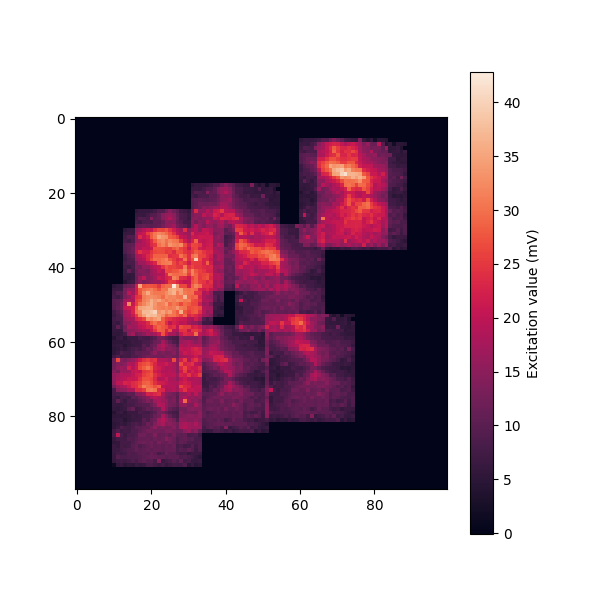

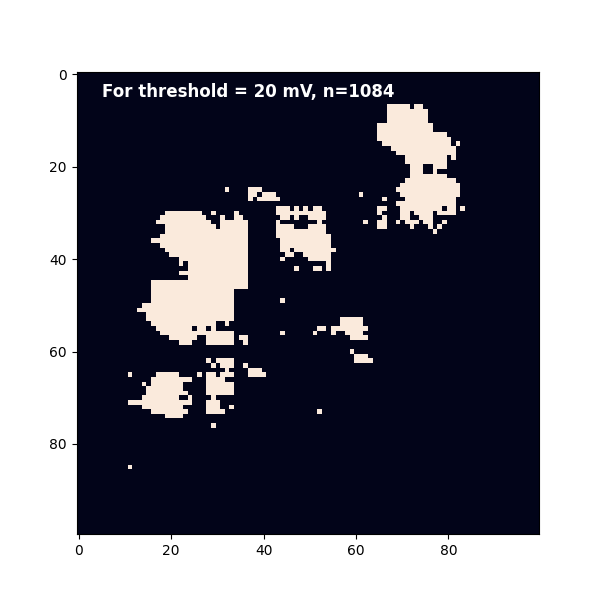

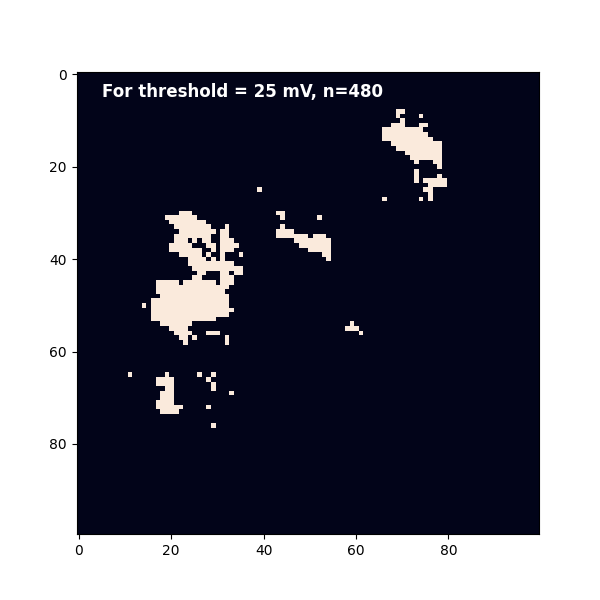

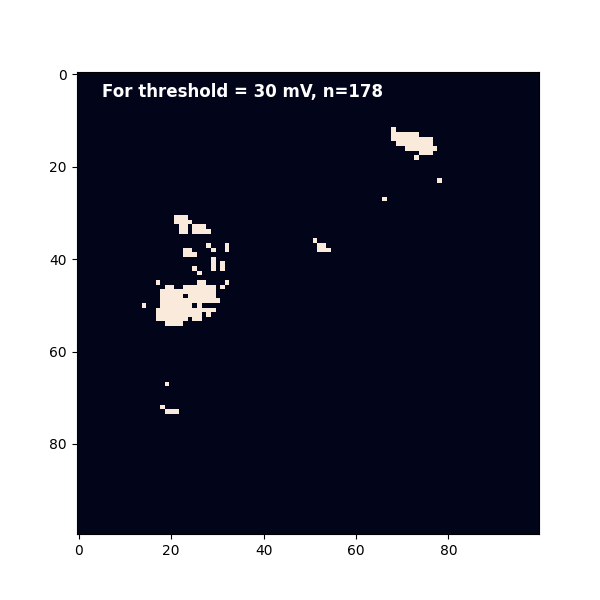

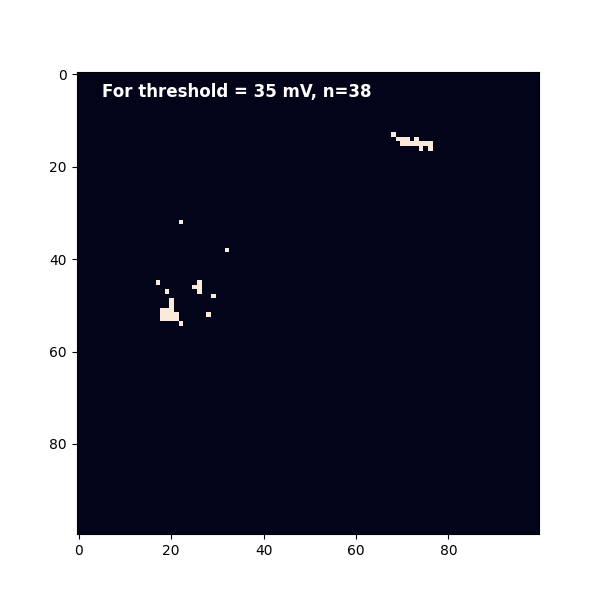

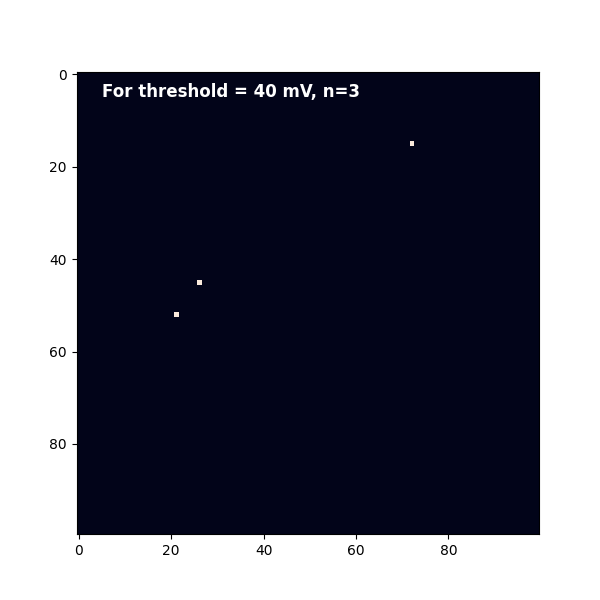

In [61]:
# create a cell layer as a numpy array of 100 x 100 neurons. Randomly select 10 neurons from the whole layer and apply the kernel to them
cell_layer = np.zeros((100,100))
# use a particular random seed state
np.random.seed(0)
neuron_locs = np.random.randint(20, 80,(10,2))
for loc in neuron_locs:
    cell_layer[loc[0],loc[1]] = 1

# apply the kernel to the cell layer for each neuron and add the kernel value for each location
output = np.zeros((100,100))

# import cv2

# output = cv2.filter2D(src=cell_layer, ddepth=-1, kernel=kernel)

# plt.figure()
# plt.imshow(cell_layer, cmap='rocket', interpolation='nearest')
# plt.figure()
# plt.imshow(output, cmap='rocket', interpolation='nearest')
for loc in neuron_locs:
    x1 = loc[0]-13
    x2 = loc[0]+11
    y1 = loc[1]-14
    y2 = loc[1]+15
    # print(x1,x2,x2-x1, y1,y2, y2-y1, kernel.shape)
    output[y1:y2, x1:x2] += kernel
figin, axin = plt.subplots(figsize=(6,6))
axin.imshow(cell_layer, cmap='rocket', interpolation='nearest')
# save fig
figin.savefig(fig_folder / f'kernel_convolution_input_cell_layer.svg')
figin.savefig(fig_folder / f'kernel_convolution_input_cell_layer.png')

figout, axout = plt.subplots(figsize=(6,6))
axout.imshow(output, cmap='rocket', interpolation='nearest')
# colourbar
cbar = plt.colorbar(axout.imshow(output, cmap='rocket', interpolation='nearest'))
cbar.set_label('Excitation value (mV)')
# save fig
figout.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer.svg')
figout.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer.png')

# create a new array by thresholding the output array
threshold = [20,25,30,35,40]
for th in threshold:
    output_thresholded = np.zeros_like(output)
    output_thresholded[output>th] = 1
    # plot in a new figure
    figout_thresh, axout_thresh = plt.subplots(figsize=(6,6))
    axout_thresh.imshow(output_thresholded, cmap='rocket', interpolation='nearest')
    # annotate the total number of neurons activated in the figure
    neurons_crossing_threshold = np.sum(output_thresholded)
    axout_thresh.text(5,5,f'For threshold = {th} mV, n={int(neurons_crossing_threshold)}', color='white', fontsize=12, fontweight='bold')
    # save fig
    figout_thresh.savefig(fig_folder / f'kernel_convolution_{th}_thresholded_cell_layer.svg')
    figout_thresh.savefig(fig_folder / f'kernel_convolution_{th}_thresholded_cell_layer.png')
    print(f'actual number of neurons activated: {np.sum(output_thresholded)}')

In [ ]:
#

actual number of neurons activated: 1894.0
actual number of neurons activated: 1084.0
actual number of neurons activated: 480.0
actual number of neurons activated: 178.0
actual number of neurons activated: 38.0
actual number of neurons activated: 3.0


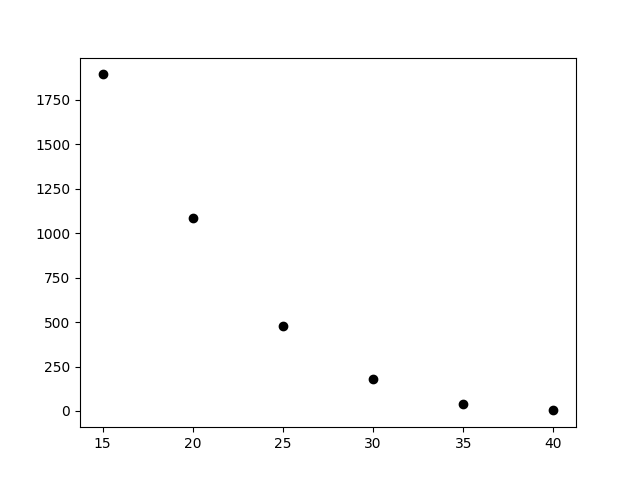

In [57]:
plt.figure()

for i in [15,20,25,30,35,40]:
    output_thresholded = np.zeros_like(output)
    output_thresholded[output>i] = 1
    print(f'actual number of neurons activated: {np.sum(output_thresholded)}')
    plt.scatter(i, np.sum(output_thresholded), color='black')
plt.show()
plt.xlabel('Threshold (a.u.)')
plt.ylabel('Number of activated neurons')
# remove top and right spines
sns.despine()
# save fig
plt.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer_numactivatedcells.svg')
plt.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer_numactivatedcells.png')
    

Loading ABF file
Datafile has 1 sweeps in 2 channels.


c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


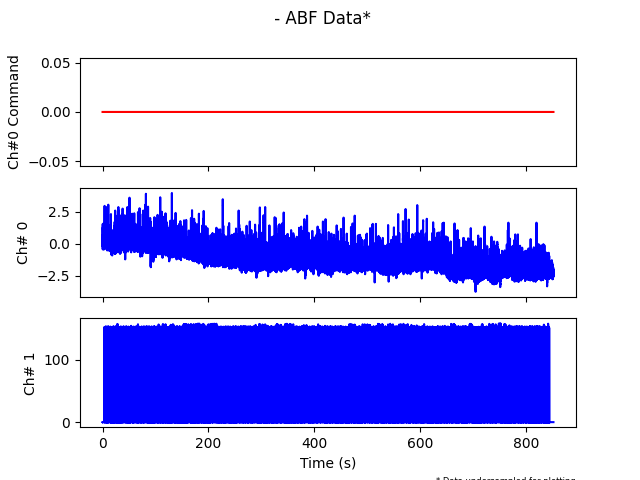

In [16]:
from asymmetry import abf_to_data as ad
from asymmetry import utils


# a function to use stim times, slice the cell data, find the max, 
# and plot the max value on the corresponding coordinate taken from 
# pattern_order dataframe column 3 on a grid


    
data = ad.abf_to_data(file_path, baseline_subtraction=True,
        signal_scaling=1, sampling_freq=2e4, filter_type='', filter_cutoff=1000,
        data_order="channelwise", plot_data=True)[0][0]

data = data.ravel()

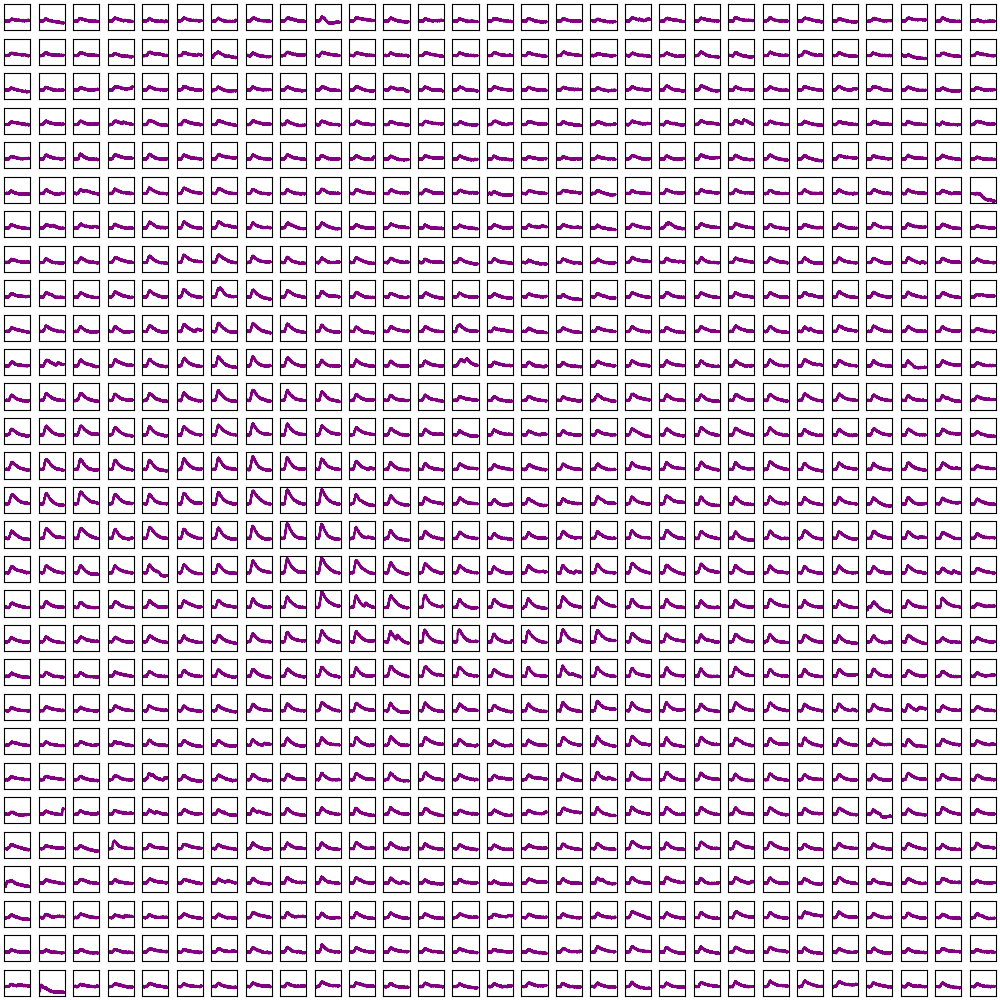

In [17]:
fig, ax = plt.subplots(29,29, figsize=(10,10), sharex=True, sharey=True, layout='constrained')

for k in range(841):
    T0 = -25
    T1 = 175
    x,y = peak_df['x'][k], peak_df['y'][k]
    t0 = int(stim_times[k] + T0*20)
    t1 = int(stim_times[k] + T1*20)
    cellslice = data[t0:t1]
    cellslice = cellslice - np.mean(cellslice[:500])
    ax[x,y].plot(np.linspace(T0, T1, len(cellslice)), cellslice, 'purple')
    # remove all ticks, ticklabels, but keep the bounding box
    ax[x,y].set_xticks([])
    ax[x,y].set_yticks([])
    # ax[x,y].spines['top'].set_visible(False
    # print(k,x,y)
# save fig
filename_prefix = f'CaMKII_27Apr18_expt10'
fig.savefig(fig_folder / f'{filename_prefix}_raw_data.svg')
fig.savefig(fig_folder / f'{filename_prefix}_raw_data.png')


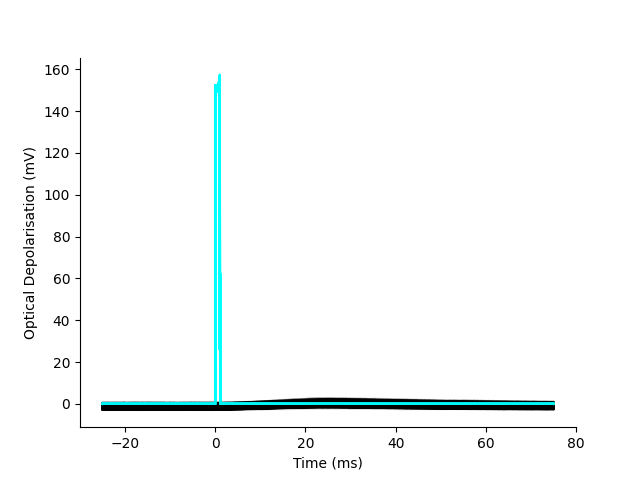

In [46]:
# plot
fig3, ax3 = plt.subplots()
T0,T1 = -25,75
Fs=20
for st in stim_times:
    # print(st)
    t0, t1 = int(st+T0*Fs), int(st+T1*Fs)
    stim_slice = stim[t0:t1]
    cell_slice = cell[t0:t1]
    cellmax = np.max(cell_slice)
    cellauc = np.trapz(cell_slice) / 20000
    time = np.linspace(T0, T1, len(cell_slice))
    if cellmax>12:
        ax3.plot(time, cell_slice, 'blue', alpha=0.1)
    else:
        ax3.plot(time, cell_slice, 'black', alpha=0.1)
    ax3.plot(time, stim_slice, 'cyan', alpha=0.1)

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Optical Depolarisation (mV)')
# remove spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# save fig
fig3.savefig(fig_folder / f'{filename_prefix}_raw_traces.svg')

In [28]:
# scipy to open matlab files
from scipy.io import loadmat
import h5py
import scipy.io as sio

c:\venvs\venv-ephys\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'AnalysedFile', 'AnalysedFilePath', 'AucImageFile', 'ExptID', 'FileName', 'OrderFileName', 'OrderFilePathName', 'PatchTrace', 'PatchTracelets', 'PathName', 'PeakImageFile', 'PolygonTrace', 'PolygonTracelet', 'TimeTrace', 'TraceFile', 'aucDuration', 'aucTime', 'gridAuc', 'None', 'gridOrder', 'gridPeak', 'gridSize', 'j', 'locs', 'orderFile', 'peaks', 'responseImageFile', '__function_workspace__'])


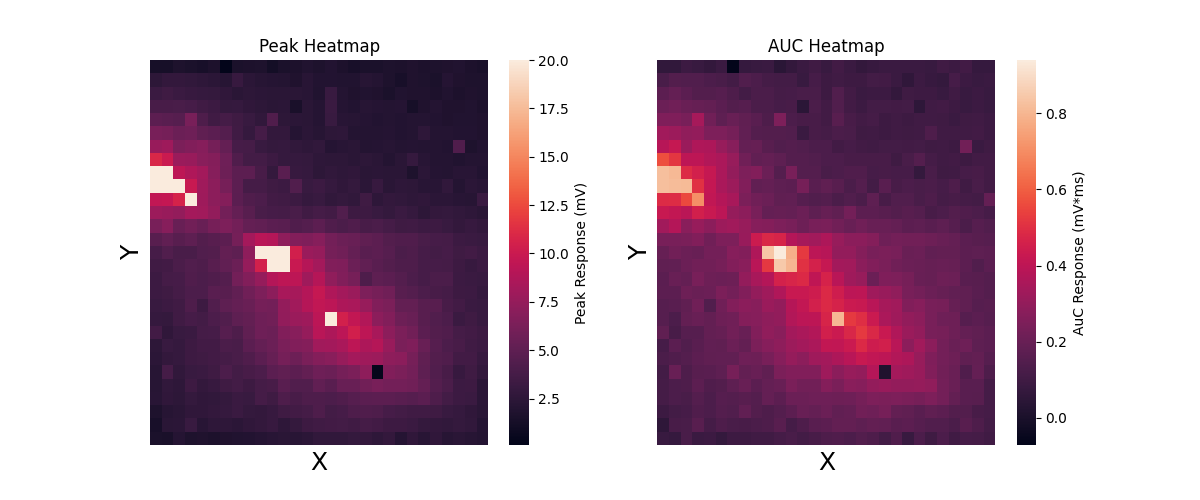

In [69]:
# load matlab files
matfile = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\May17\30May17\Expt3_300517\Expt3_300517_Ordered_Grid_29.mat") # CaMK18 300517
mat = sio.loadmat(matfile)
print(mat.keys())
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\59xgrid29roi_100perc10ms.txt")
coord = pd.read_csv(protocol_path6, header=None, sep=' ')

data = mat['PatchTracelets']
# coord = mat['coord']
# coord = coord.ravel()

fig4, [ax4_1, ax4_2] = plt.subplots(1,2, figsize=(12,5))
peakdict = []
for i,c in enumerate(coord[3]):
    x,y = (c-1)//59, (c-1)%59
    cellslice = data[i]
    cellmax = np.max(cellslice)
    cellauc = np.trapz(cellslice) / 20000
    if cellmax>20:
        cellmax=20

    peakdict.append({'x':x, 'y':y, 'peak':cellmax, 'auc':cellauc})

peak_df = pd.DataFrame(peakdict)
df_pivot_peak = peak_df.pivot(index='x', columns='y', values='peak')
df_pivot_auc  = peak_df.pivot(index='x', columns='y', values='auc')

# heatmap
sns.heatmap(df_pivot_peak, ax=ax4_1, cmap='rocket')
sns.heatmap(df_pivot_auc, ax=ax4_2, cmap='rocket')

ax4_1.set_title('Peak Heatmap')
# remove x and y labels, ticks and grid
ax4_1.set_xticks([])
ax4_1.set_yticks([])
ax4_1.set_xticklabels([])
ax4_1.set_yticklabels([])
# axs labels
ax4_1.set_xlabel('X', fontsize=18)
ax4_1.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_1.collections[0].colorbar
unit = 'mV'
cbar.set_label(f'Peak Response ({unit})')

ax4_2.set_title('AUC Heatmap')
# remove x and y labels, ticks and grid
ax4_2.set_xticks([])
ax4_2.set_yticks([])
ax4_2.set_xticklabels([])
ax4_2.set_yticklabels([])
# axs labels
ax4_2.set_xlabel('X', fontsize=18)
ax4_2.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_2.collections[0].colorbar
unit = 'mV*ms'
cbar.set_label(f'AuC Response ({unit})')

filename_prefix = f'CaMK18_300517_expt03'
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.svg')
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.png')

c:\venvs\venv-ephys\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'AnalysedFile', 'AnalysedFilePath', 'AucImageFile', 'ExptID', 'FileName', 'PatchTrace', 'PatchTracelets', 'PathName', 'PeakImageFile', 'PolygonTrace', 'TimeTrace', 'TraceFile', 'ans', 'aucDuration', 'aucTime', 'coord', 'coordFileName', 'coordFilePathName', 'fid', 'gridAuc', 'None', 'gridPeak', 'gridSize', 'j', 'locs', 'peaks', '__function_workspace__'])


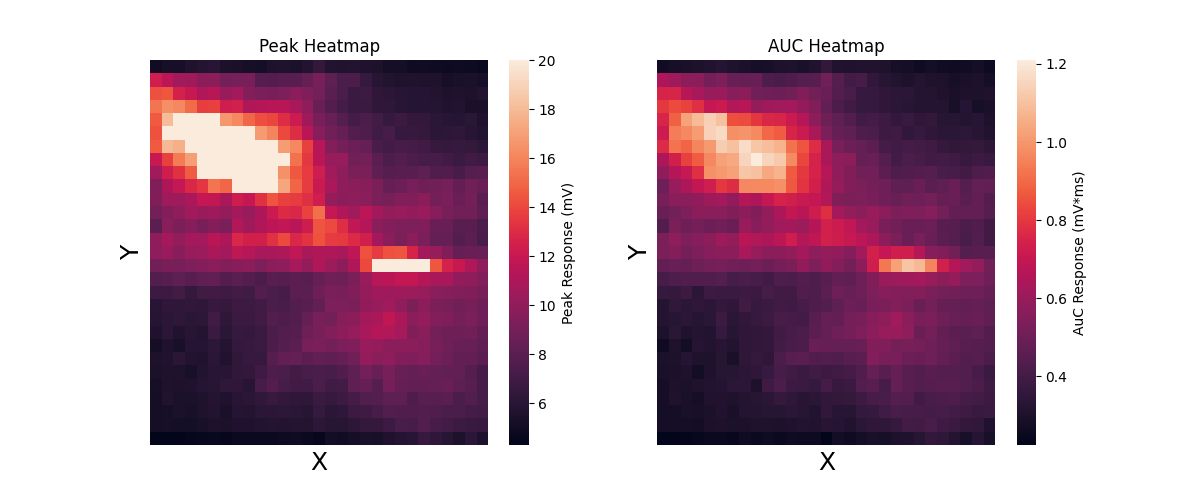

In [70]:
# load matlab files
matfile = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\Aug17\17Aug17\Expt05_170817\Expt05_170817_Ordered_Grid_29.mat")
mat = sio.loadmat(matfile)
print(mat.keys())
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\Aug17\17Aug17\Expt05_grid29_random.txt")
coord = pd.read_csv(protocol_path6, header=None, sep=' ')

data = mat['PatchTracelets']
# coord = mat['coord']
# coord = coord.ravel()

fig4, [ax4_1, ax4_2] = plt.subplots(1,2, figsize=(12,5))
peakdict = []
for i,c in enumerate(coord[3]):
    x,y = (c-1)//29, (c-1)%29
    cellslice = data[i]
    cellmax = np.max(cellslice)
    cellauc = np.trapz(cellslice) / 20000
    if cellmax>20:
        cellmax=20

    peakdict.append({'x':x, 'y':y, 'peak':cellmax, 'auc':cellauc})

peak_df = pd.DataFrame(peakdict)
df_pivot_peak = peak_df.pivot(index='x', columns='y', values='peak')
df_pivot_auc  = peak_df.pivot(index='x', columns='y', values='auc')

# heatmap
sns.heatmap(df_pivot_peak, ax=ax4_1, cmap='rocket')
sns.heatmap(df_pivot_auc, ax=ax4_2, cmap='rocket')

ax4_1.set_title('Peak Heatmap')
# remove x and y labels, ticks and grid
ax4_1.set_xticks([])
ax4_1.set_yticks([])
ax4_1.set_xticklabels([])
ax4_1.set_yticklabels([])
# axs labels
ax4_1.set_xlabel('X', fontsize=18)
ax4_1.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_1.collections[0].colorbar
unit = 'mV'
cbar.set_label(f'Peak Response ({unit})')

ax4_2.set_title('AUC Heatmap')
# remove x and y labels, ticks and grid
ax4_2.set_xticks([])
ax4_2.set_yticks([])
ax4_2.set_xticklabels([])
ax4_2.set_yticklabels([])
# axs labels
ax4_2.set_xlabel('X', fontsize=18)
ax4_2.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_2.collections[0].colorbar
unit = 'mV*ms'
cbar.set_label(f'AuC Response ({unit})')

filename_prefix = f'CaMK31_170817_expt05'
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.svg')
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.png')